In [1]:
%matplotlib inline

# DataFrame
import pandas as pd

# Elasticsearch
from elasticsearch import Elasticsearch, helpers

# datetime
from datetime import datetime

# isnan()
import math

# plot
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# Change plot style to ggplot
plt.style.use('ggplot')

### simply plot packet loss for different links

1.  UC -> IU


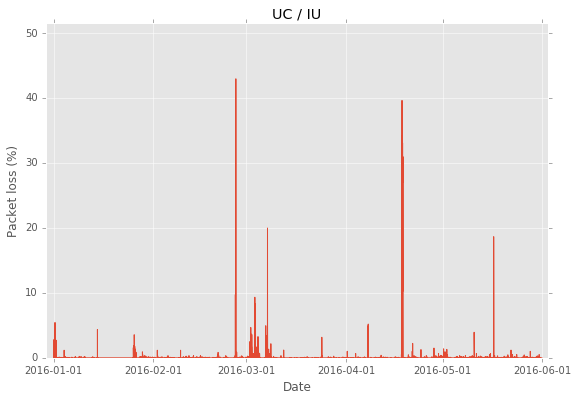

2.  UC -> UIUC


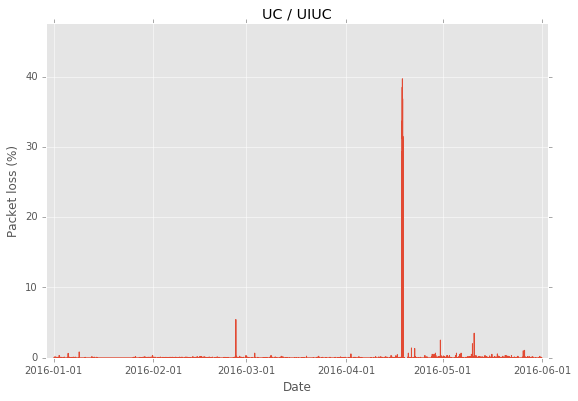

3.  UC -> SFU


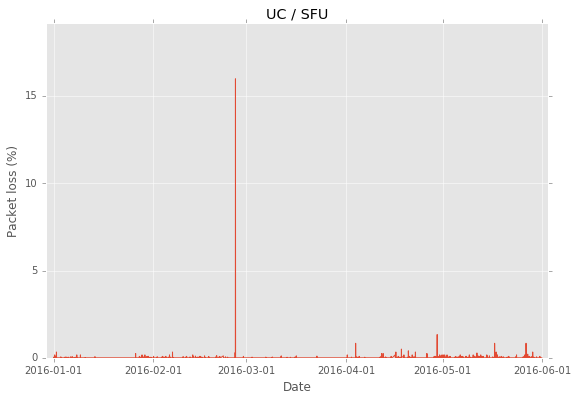

4.  UC -> CERN


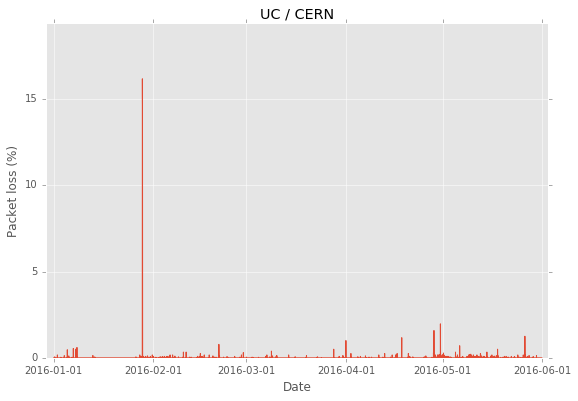

5.  UC -> BEIJING


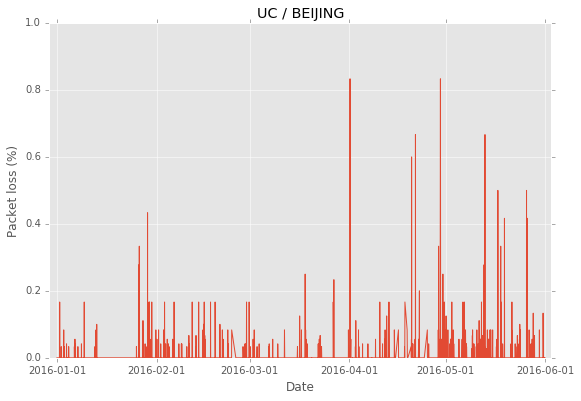

6.  IU -> UC


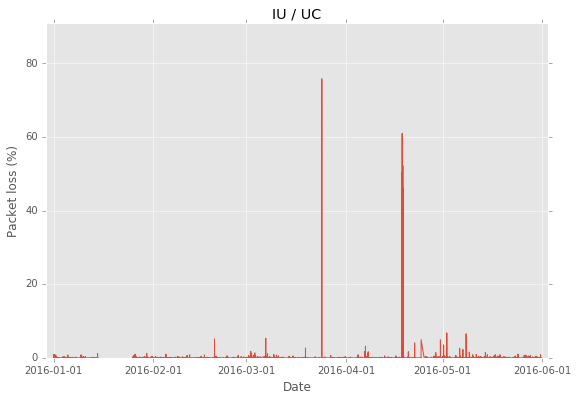

7.  IU -> UIUC


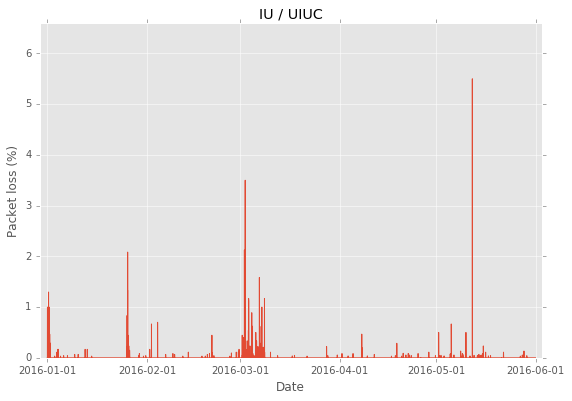

8.  IU -> SFU


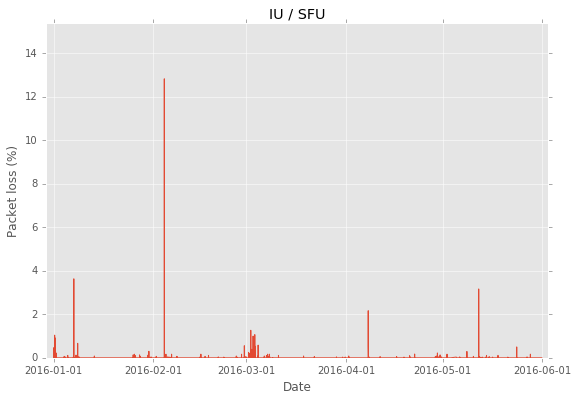

9.  IU -> CERN


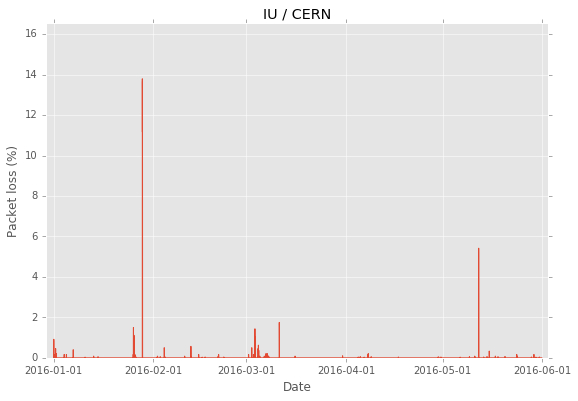

10.  IU -> BEIJING


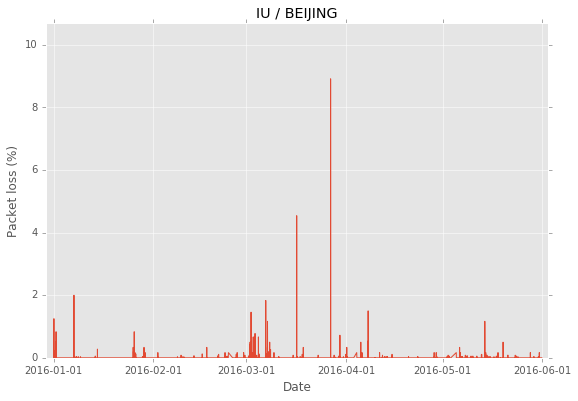

11.  UIUC -> UC


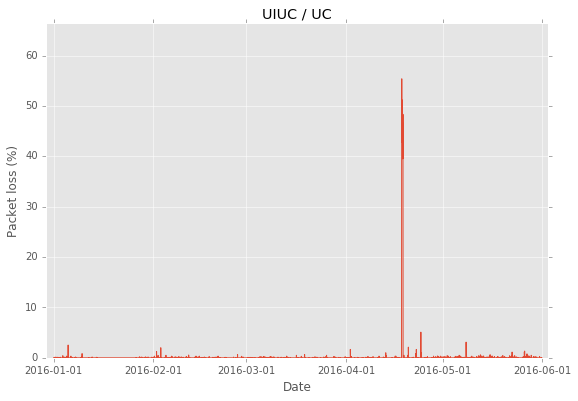

12.  UIUC -> IU


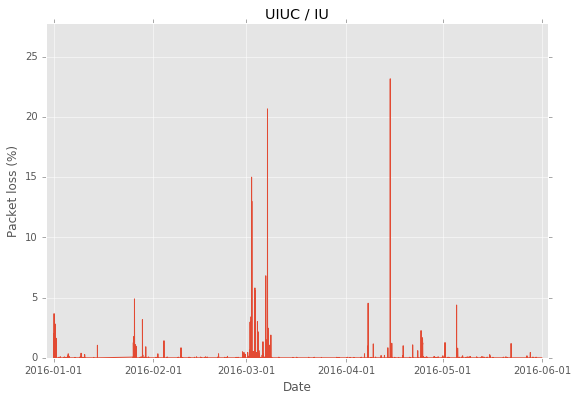

13.  UIUC -> SFU


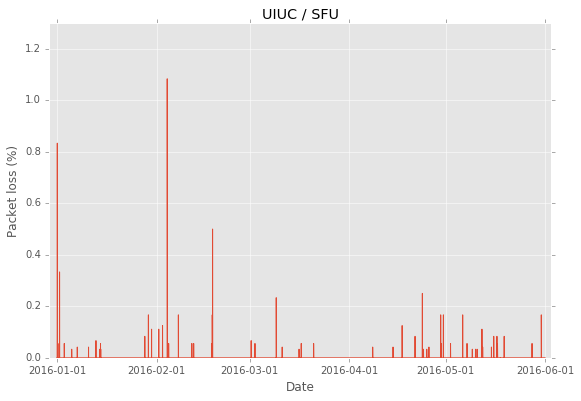

14.  UIUC -> CERN


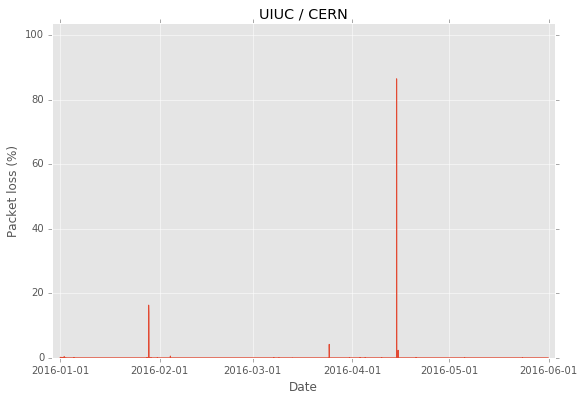

15.  UIUC -> BEIJING


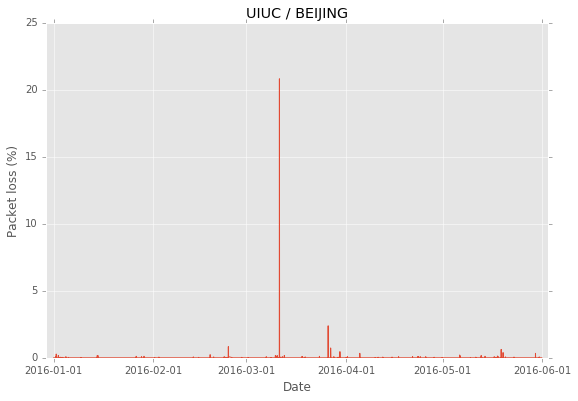

16.  SFU -> UC


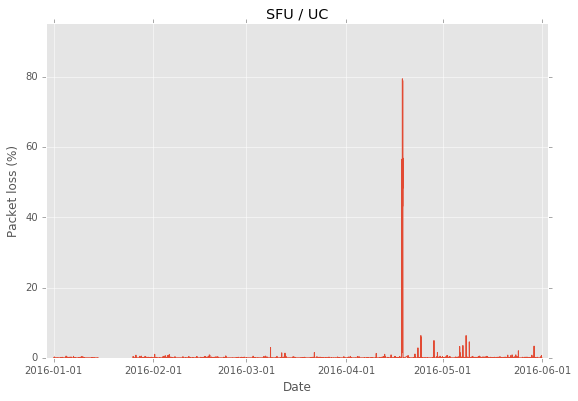

17.  SFU -> IU


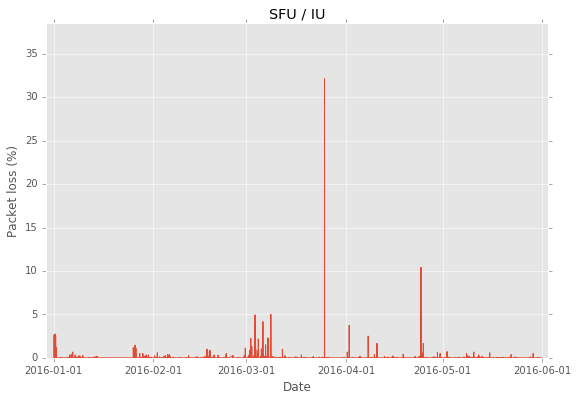

18.  SFU -> UIUC


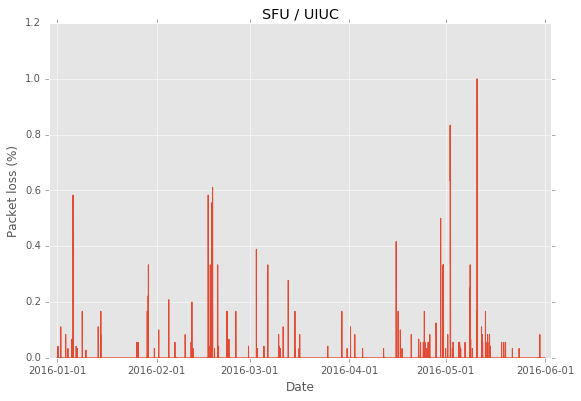

19.  SFU -> CERN


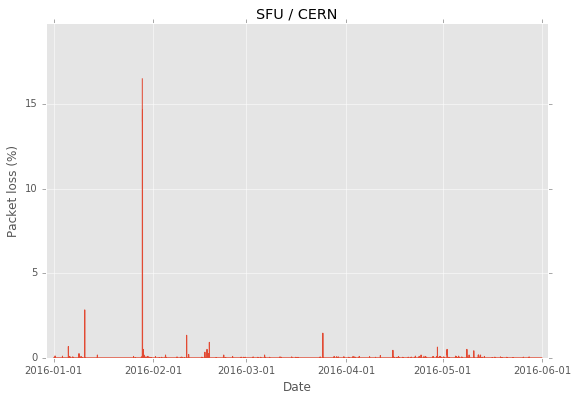

20.  SFU -> BEIJING


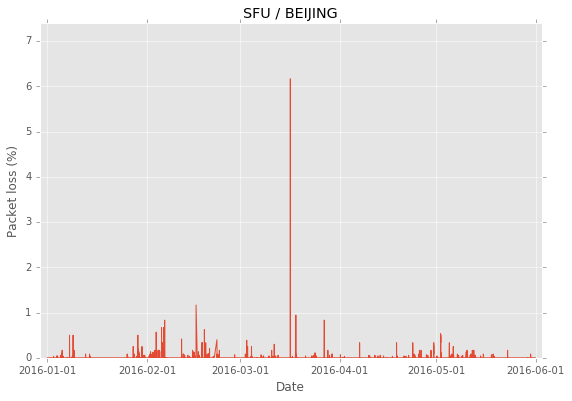

21.  CERN -> UC


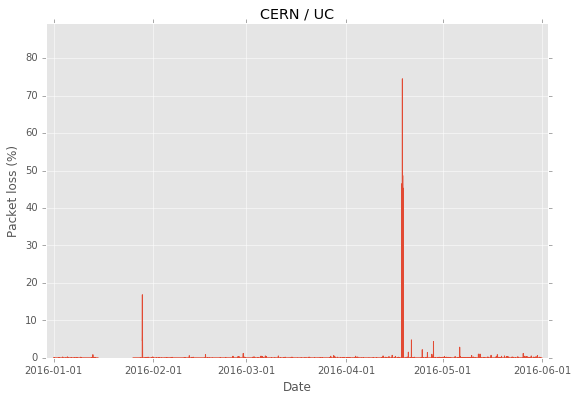

22.  CERN -> IU


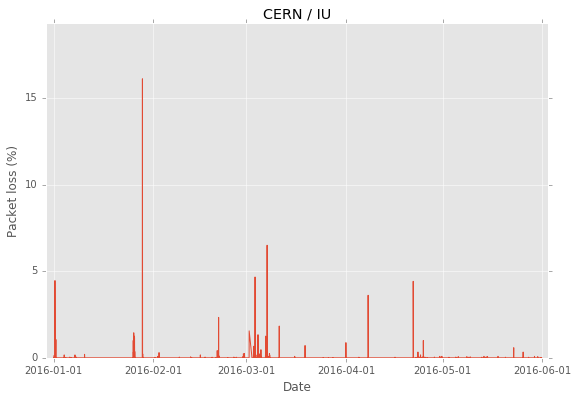

23.  CERN -> UIUC


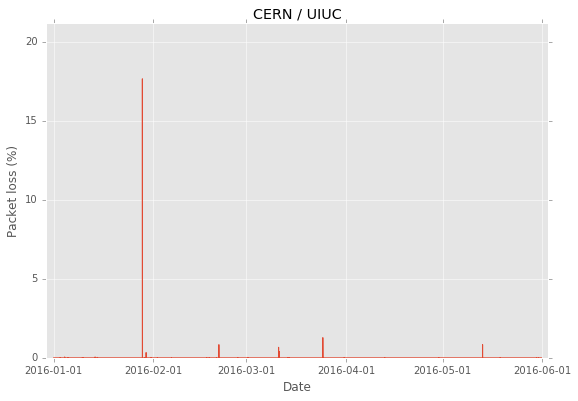

24.  CERN -> SFU


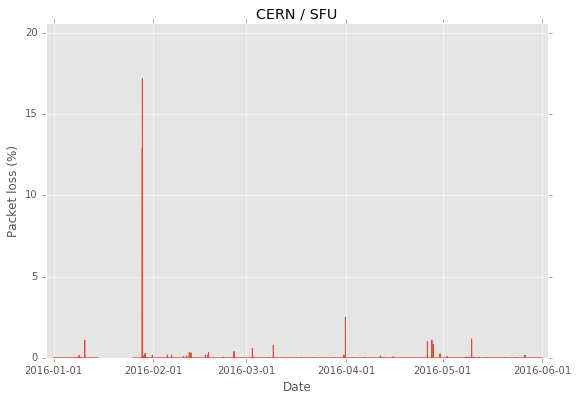

25.  CERN -> BEIJING


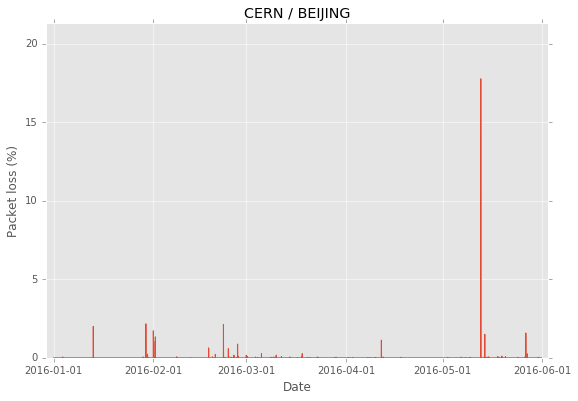

26.  BEIJING -> UC


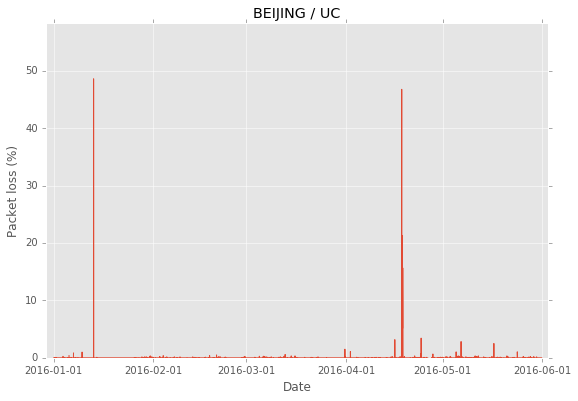

27.  BEIJING -> IU


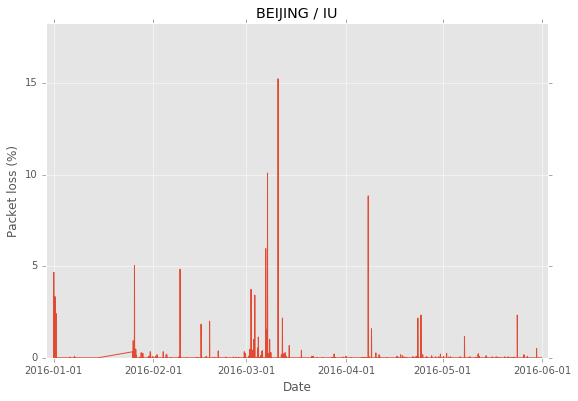

28.  BEIJING -> UIUC


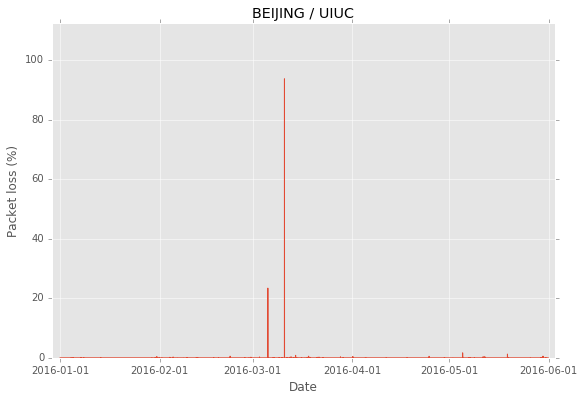

29.  BEIJING -> SFU


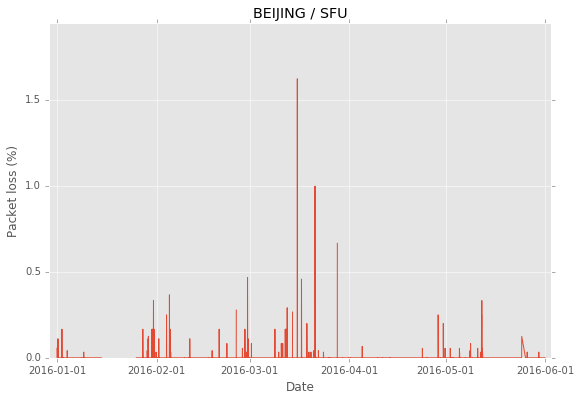

30.  BEIJING -> CERN


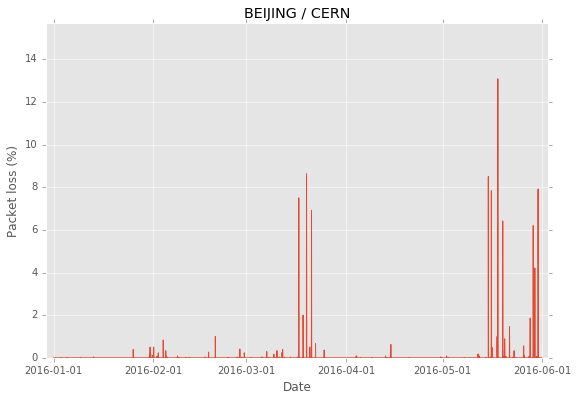

In [2]:
# Site names
name_list = ['UC', 'IU', 'UIUC', 'SFU', 'CERN', 'BEIJING']
# IP addresses of latency and packet loss servers
ip_list_lpl = ['192.170.227.160', '149.165.225.223', '72.36.96.4', '206.12.24.251', '128.142.223.247', '202.122.32.170']
# IP addresses of throughput servers (not used in this notebook)
ip_list_t = ['192.170.227.162', '149.165.225.224', '72.36.96.9', '206.12.24.250', '128.142.223.246', '202.122.32.166']

countbig = 0
for src_i in range(6):
    for dest_i in range(6):
        if src_i != dest_i:   # Every link between two different sites
            countbig += 1
            print('{}.  {} -> {}'.format(countbig, name_list[src_i], name_list[dest_i]))
            
            # Read in the data stored as pickle files on disk
            data_lpl = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(ip_list_lpl[src_i], ip_list_lpl[dest_i]))
            
            # To display date as x-axis labels
            x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
            lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']
            
            # Get the data
            time_lpl = data_lpl.index    # Time
            dm = data_lpl.delay_median         # delay_median (ms)
            pl = data_lpl.packet_loss * 100    # packet loss (%)

            dm_median = dm.median()   # The median value of delay
            pl_median = pl.median()   # The median value of packet loss

#             set_dm = set()  # Store the anomaly for delay
#             set_pl = set()  # Store the anomaly for packet loss
#             
#             row = data_lpl.shape[0]
#             for r in range(row):
#                 line = data_lpl.iloc[r]
#                 value1 = abs(line['delay_median'] - dm_median)
#                 value2 = abs(line['packet_loss'] * 100 - pl_median)
#                 if value1 > 5:   # If delay is too large or too small compared to its median value, then it is anomaly
#                     set_dm.add(data_lpl.index[r])
#                 if value2 > 2:   # If packet loss is too large or too small compared to its median value, then it is anomaly
#                     set_pl.add(data_lpl.index[r])
            
            plt.figure(figsize=[9, 6])

            plt.title('{} / {}'.format(name_list[src_i], name_list[dest_i]))
            
            plt.subplot(1, 1, 1)
            plt.plot(time_lpl, pl, label='Packet loss (%)')
            plt.ylabel('Packet loss (%)')
            plt.ylim([0, pl.max() * 1.2])
            plt.xlim([1451400000000, 1464900000000])
            plt.xticks(x, lbl, rotation=0)
            
            plt.xlabel('Date')
            plt.show()

## Packet loss: triger alert if packet loss is > 2%, do not alert again for the following day

1.  UC -> IU


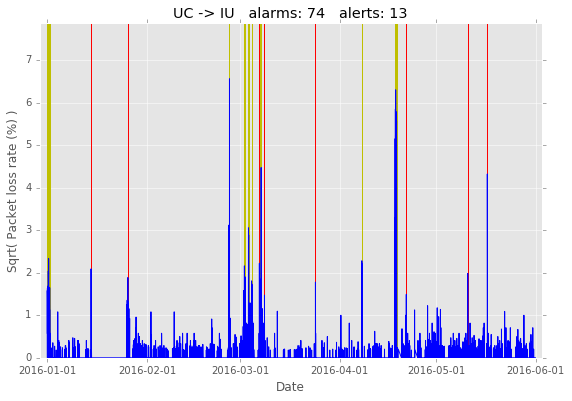

2.  UC -> UIUC


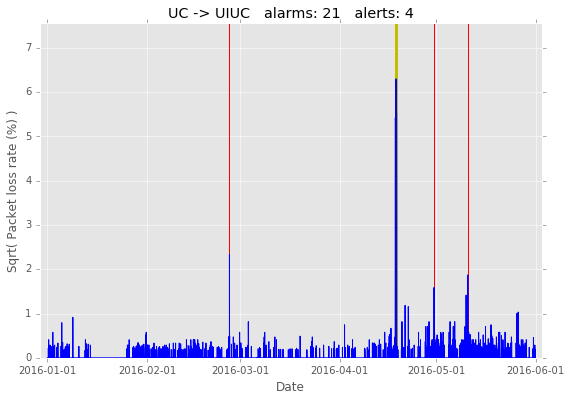

3.  UC -> SFU


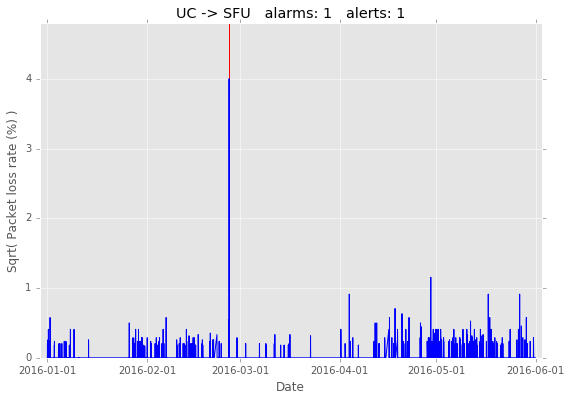

4.  UC -> CERN


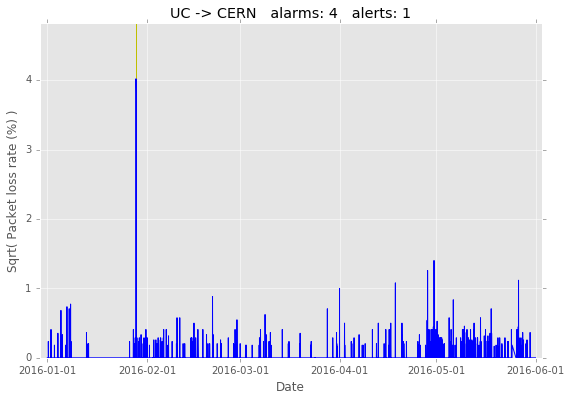

5.  UC -> BEIJING


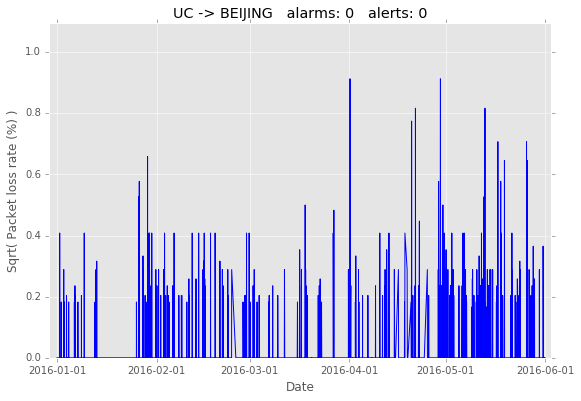

6.  IU -> UC


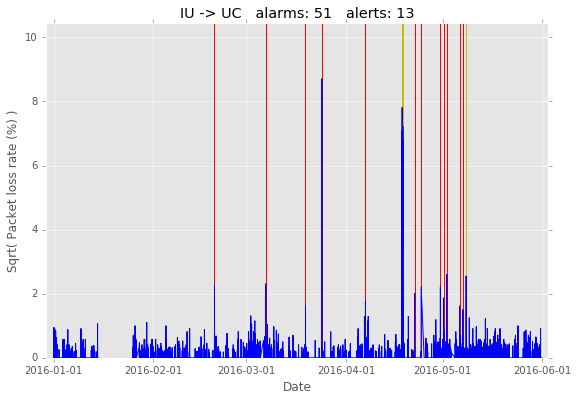

7.  IU -> UIUC


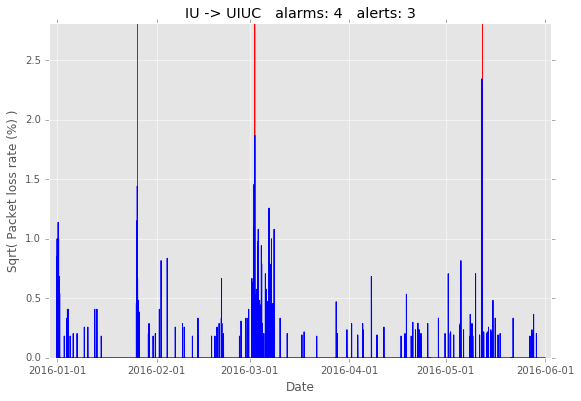

8.  IU -> SFU


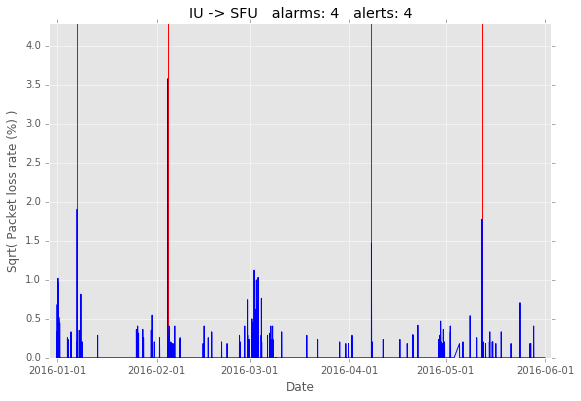

9.  IU -> CERN


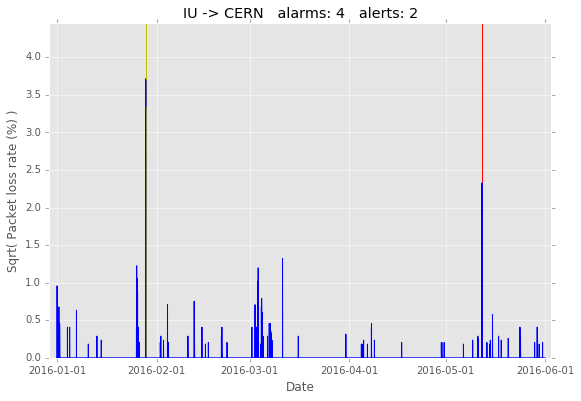

10.  IU -> BEIJING


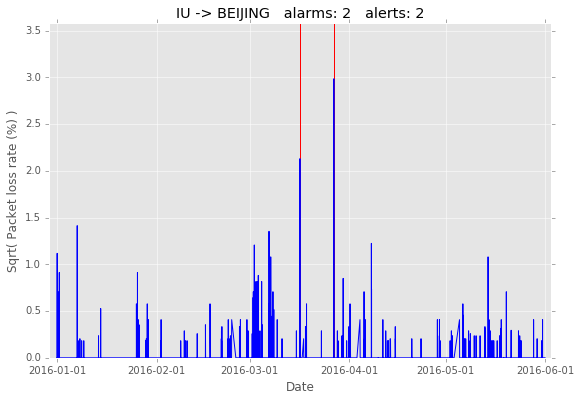

11.  UIUC -> UC


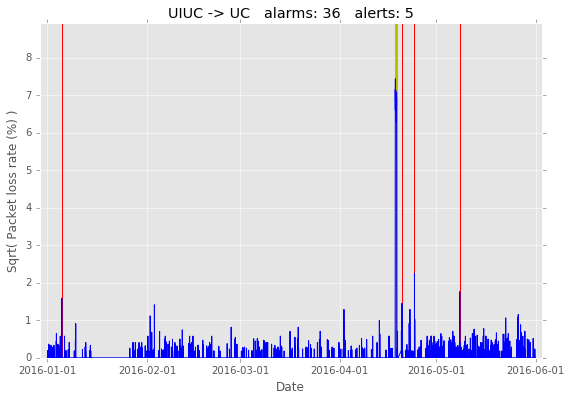

12.  UIUC -> IU


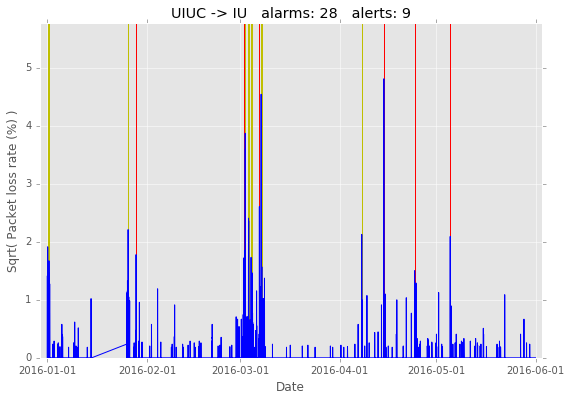

13.  UIUC -> SFU


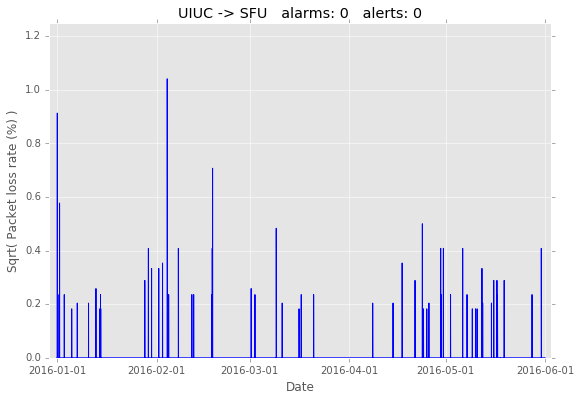

14.  UIUC -> CERN


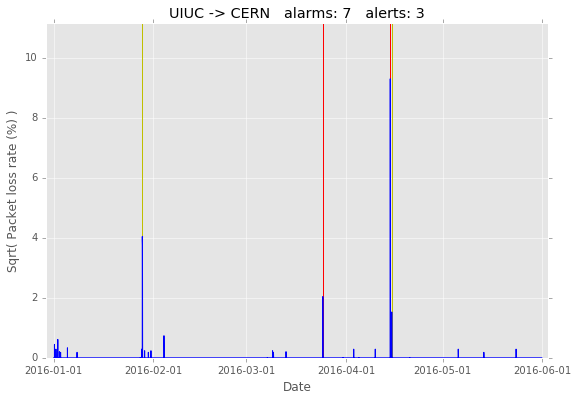

15.  UIUC -> BEIJING


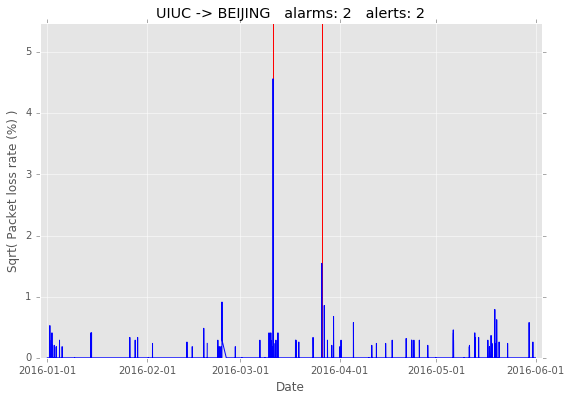

16.  SFU -> UC


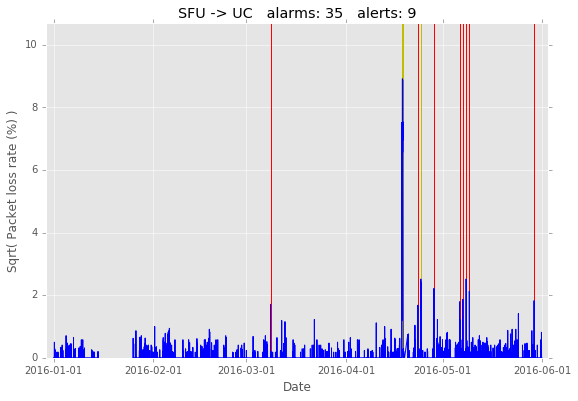

17.  SFU -> IU


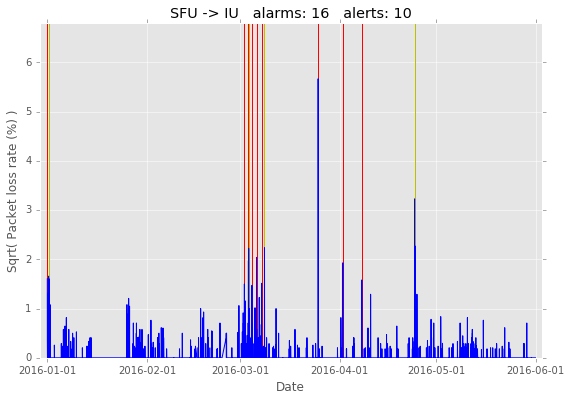

18.  SFU -> UIUC


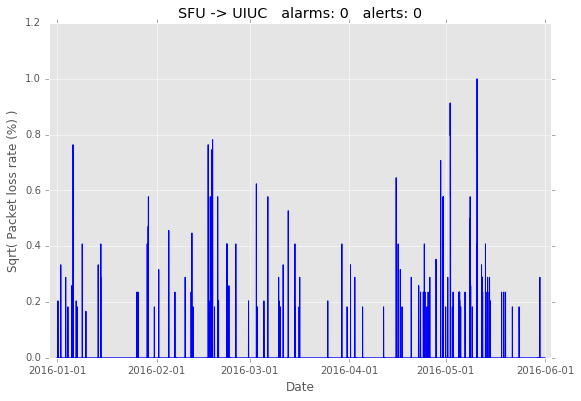

19.  SFU -> CERN


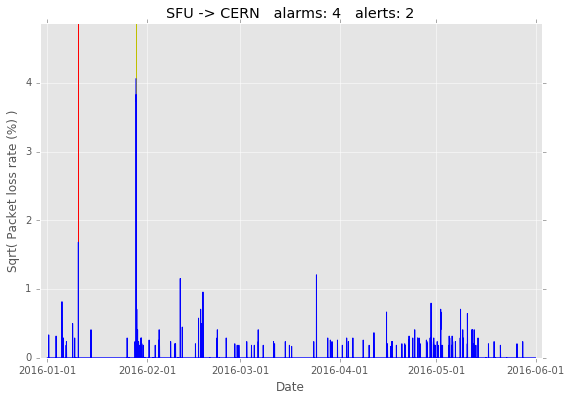

20.  SFU -> BEIJING


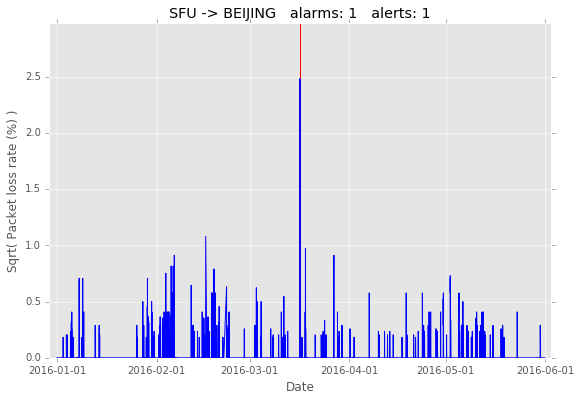

21.  CERN -> UC


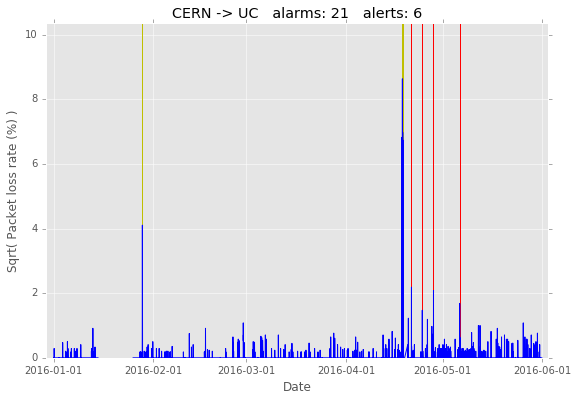

22.  CERN -> IU


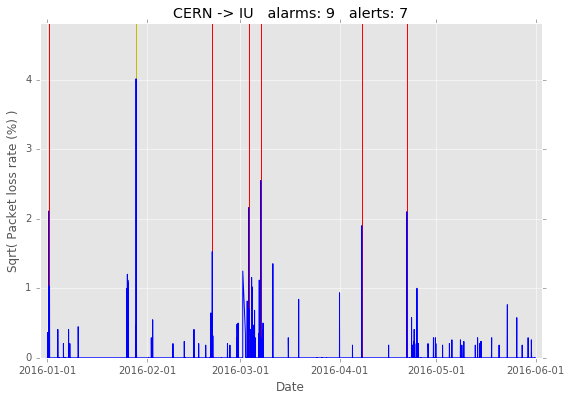

23.  CERN -> UIUC


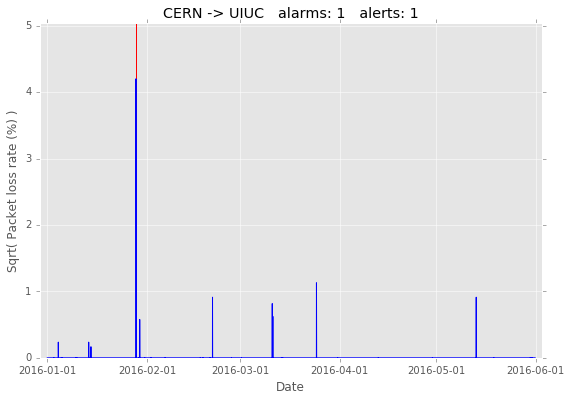

24.  CERN -> SFU


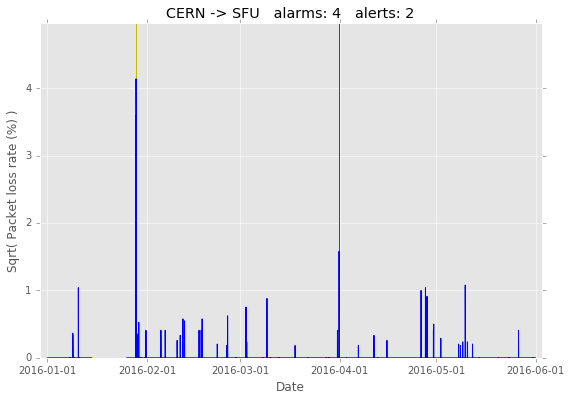

25.  CERN -> BEIJING


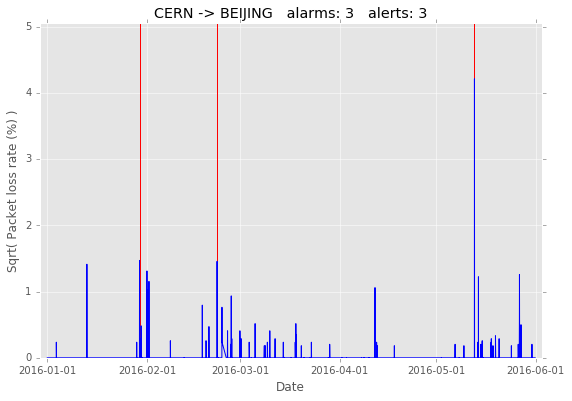

26.  BEIJING -> UC


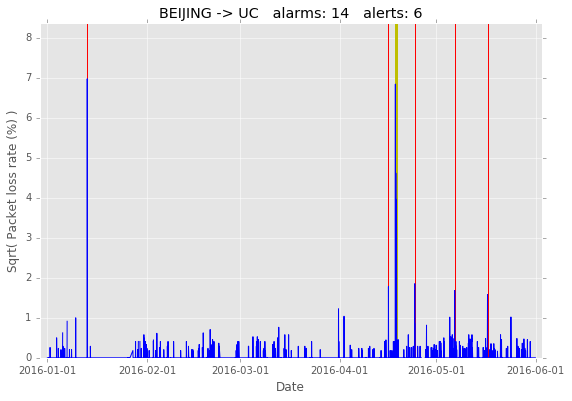

27.  BEIJING -> IU


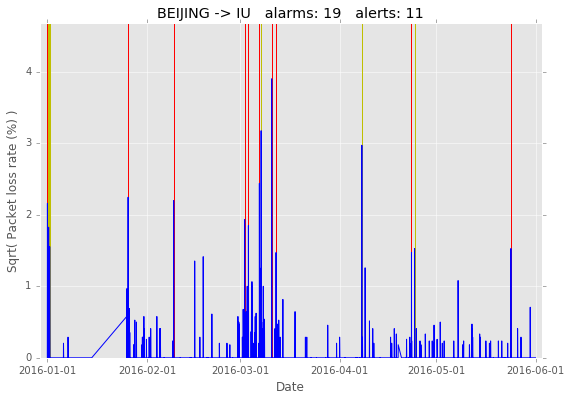

28.  BEIJING -> UIUC


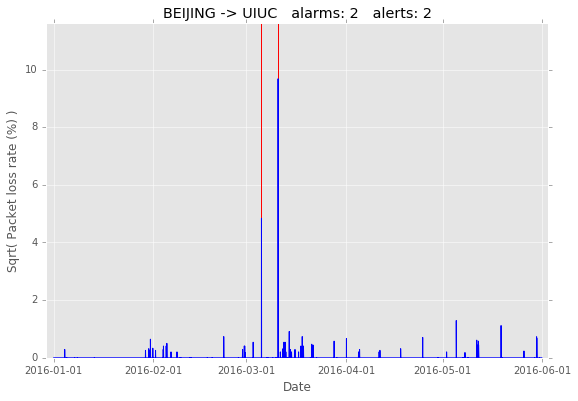

29.  BEIJING -> SFU


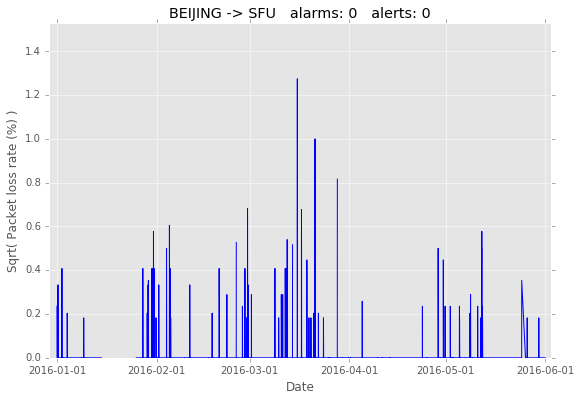

30.  BEIJING -> CERN


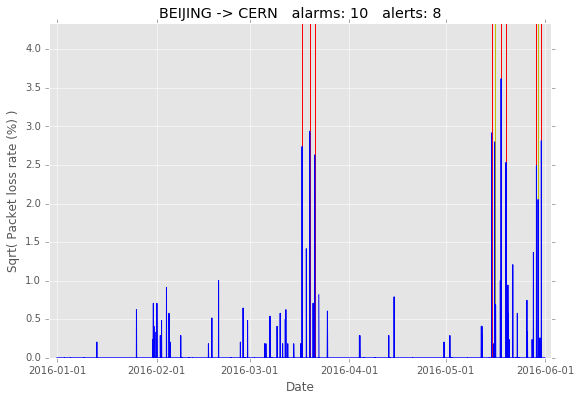

In [10]:
list_name = ['UC', 'IU', 'UIUC', 'SFU', 'CERN', 'BEIJING']
list_ip = ['192.170.227.160', '149.165.225.223', '72.36.96.4', '206.12.24.251', '128.142.223.247', '202.122.32.170'] # latency and packet loss server

# To display date as x-axis labels
x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']

cooldown_time = 1 * 24 * 60 * 60 * 1000   # one day, any new alert in this cooldown time is ignored
last_alert_time = 0

count_global = 0
src_index = -1
for src_ip in list_ip:
    src_index += 1
    dest_index = -1
    for dest_ip in list_ip:
        dest_index += 1
        if src_ip != dest_ip:
            count_global += 1
            print('{}.  {} -> {}'.format(count_global, list_name[src_index], list_name[dest_index]))
            
            # Read .pickle data files
            data = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(list_ip[src_index], list_ip[dest_index]))
            
            # Get the variables
            time = data.index
            pl = data.packet_loss * 100
            
            # Distinguish the anomaly (i.e. packet loss > 2%)
            time_abnormal = time[pl > 2]
            
            # Plot (calculate sqrt, so that we have a better idea of the small values when we have large values. Can not use log because of zeros)
            plt.figure(figsize=[9, 6])
            plt.ylabel('Sqrt( Packet loss rate (%) )')
            plt.xlabel('Date')
            plt.ylim([0, np.sqrt(pl).max() * 1.2])
            plt.xlim([1451400000000, 1464900000000])
            plt.xticks(x, lbl, rotation=0)
            
            # Mark the red vertical lines, i.e. all alarms
            for t in time_abnormal:
                plt.axvline(x=t, ymin=0, ymax=10000, color='r')
            
            # Mark the yellow vertical lines, i.e. all alarms excluding repeated ones in the following one day
            yellow = 0
            for t in range(1, len(time_abnormal)):
                if time_abnormal[t]-time_abnormal[t-1] < cooldown_time:
                    plt.axvline(x=time_abnormal[t], ymin=0, ymax=10000, color='y')
                    yellow += 1
            
            # Plot the time series of packet loss itself
            plt.plot(time, np.sqrt(pl), label='xxxxxx', color='b')
            tit = list_name[src_index] + ' -> ' + list_name[dest_index] + '   alarms: '+str(len(time_abnormal)) + '   alerts: '+ str(len(time_abnormal)-yellow)
            plt.title(tit)
            plt.savefig( 'Plots/'+ tit + '.png', fmt='png', dpi=100 )
            plt.show()
            

# For NA Throughput Meeting 08/16/2016

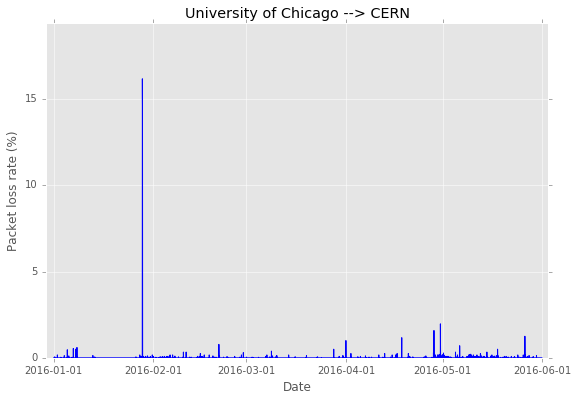

In [11]:
src_ip = '192.170.227.160'
src_name = 'University of Chicago'
dest_ip = '128.142.223.247'
dest_name = 'CERN'

x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']

data = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_ip, dest_ip))
time = data.index
pl = data.packet_loss * 100

time_abnormal = time[pl > 2]

plt.figure(figsize=[9, 6])
plt.ylabel('Packet loss rate (%)')
plt.xlabel('Date')
plt.ylim([0, pl.max() * 1.2])
plt.xlim([1451400000000, 1464900000000])
plt.xticks(x, lbl, rotation=0)
plt.title('{} --> {}'.format(src_name, dest_name))
plt.plot(time, pl, color='b')

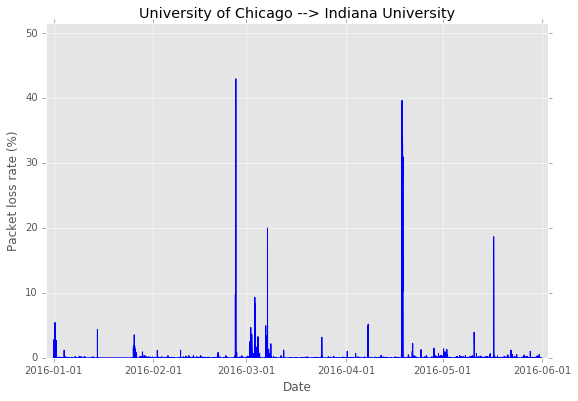

In [13]:
src_ip = '192.170.227.160'
src_name = 'University of Chicago'
dest_ip = '149.165.225.223'
dest_name = 'Indiana University'

x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']

data = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_ip, dest_ip))
time = data.index
pl = data.packet_loss * 100

time_abnormal = time[pl > 2]

plt.figure(figsize=[9, 6])
plt.ylabel('Packet loss rate (%)')
plt.xlabel('Date')
plt.ylim([0, pl.max() * 1.2])
plt.xlim([1451400000000, 1464900000000])
plt.xticks(x, lbl, rotation=0)
plt.title('{} --> {}'.format(src_name, dest_name))
plt.plot(time, pl, color='b')

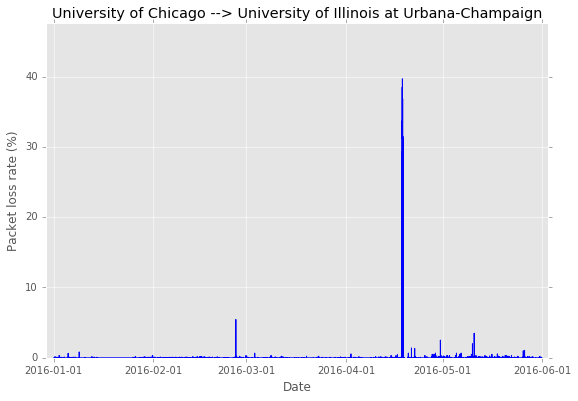

In [14]:
src_ip = '192.170.227.160'
src_name = 'University of Chicago'
dest_ip = '72.36.96.4'
dest_name = 'University of Illinois at Urbana-Champaign'

x = [1451606400000, 1454284800000, 1456790400000, 1459468800000, 1462060800000, 1464739200000]
lbl = ['2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01']

data = pd.read_pickle('My_data/week0708_clean_from_{}_to_{}.pkl'.format(src_ip, dest_ip))
time = data.index
pl = data.packet_loss * 100

time_abnormal = time[pl > 2]

plt.figure(figsize=[9, 6])
plt.ylabel('Packet loss rate (%)')
plt.xlabel('Date')
plt.ylim([0, pl.max() * 1.2])
plt.xlim([1451400000000, 1464900000000])
plt.xticks(x, lbl, rotation=0)
plt.title('{} --> {}'.format(src_name, dest_name))
plt.plot(time, pl, color='b')